# Fit transits with fewest spot occultations


### Open raw FITS files from MAST, clean out `nan`s

Save copies to `raw_long`, `raw_short` directories. 

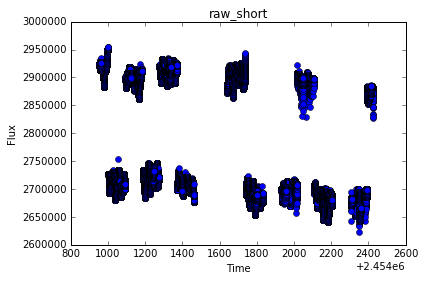

In [1]:
%matplotlib inline
import sys
sys.path.insert(0, '../')

import os
from glob import glob
from starspots.lightcurve import LightCurve, concatenate_transit_light_curves
from starspots.systemparams import rough_hat11_params

import numpy as np

path_to_fits_files = '/local/tmp/hat11/'
hat11_params = rough_hat11_params()
# Retrieve long and short cadence data
short_cadence_paths = glob(os.path.join(path_to_fits_files, '*slc.fits'))

short_lc = LightCurve.from_raw_fits(short_cadence_paths, name='raw_short',
                                    transit_params=hat11_params)
short_lc.plot()

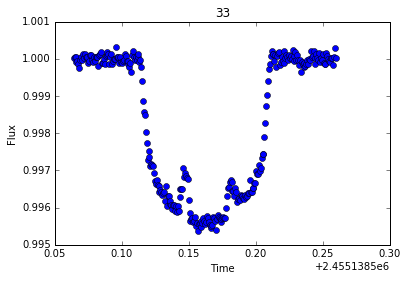

In [2]:
short_transits = LightCurve(name='transits_short', **short_lc.mask_out_of_transit())
transits = short_transits.get_transit_light_curves()


quarter_maxes = short_lc.get_quarterly_maxes()
for transit in transits:
    q = transit.quarters[0]
    transit.subtract_add_divide(quarter_maxes[q], order=2, plots=False)
    
transits[33].plot()

### Identify "spotless" transits

* do rough model fit to each transit with `scipy.optimize.fmin` including only a few transit parameters ($R_p/R_s$, $a/R_s$, $i$, $t_0$)
* Measure $\chi^2$ for best-fit model
 
**Hypothesis**: $\chi^2$ can be used as a proxy for inverse starspot-importance in each transit. Transits with low $\chi^2$ are well-described by a simple transit model, which implies they have few spot crossings. 

The distribution of $\chi^2$ shows that there's a long tail of poor fits to the data, and a handful of very good fits. The handful of very good fits all have $\log{\chi^2} < 6.5$. Any higher than 6.5 and there are readily visible spot-crossings in the transit. Now filter out only these transits with $\log{\chi^2} < 6.5$ for detailed transit analysis.

### Combine "spotless" light curves, fit model

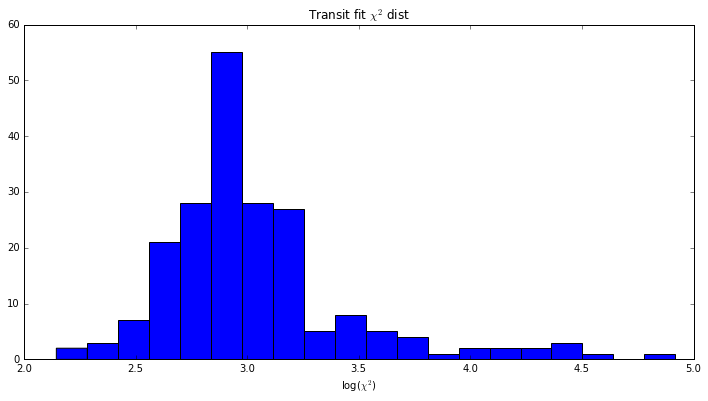

In [3]:
chi2 = []
depths = []
for transit in transits:
    p, chi = transit.fiducial_transit_fit()
    depths.append(p[0])
    chi2.append(chi)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(np.log(chi2), 20)
ax.set(xlabel=r'log($\chi^2$)', title=r'Transit fit $\chi^2$ dist')
plt.show()

# spotless transits: 10


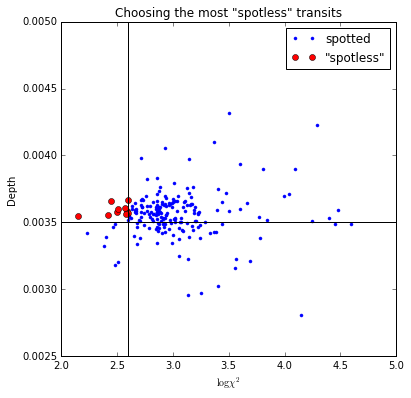

In [4]:
#chi2_threshold = 6.1
#depth_threshold = 0.003513

chi2_threshold = 2.5995
depth_threshold = 0.0035

spotless_transit_inds = (np.log(chi2) < chi2_threshold) * (np.array(depths) > depth_threshold)
spotless_transits = concatenate_transit_light_curves([transit for i, transit in enumerate(transits) 
                                                      if spotless_transit_inds[i]], name='spotless_transits')

print('# spotless transits: {}'.format(np.count_nonzero(spotless_transit_inds)))
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(np.log(chi2), depths, '.', label='spotted')
ax.plot(np.log(chi2)[spotless_transit_inds], 
        np.array(depths)[spotless_transit_inds], 'ro', label='"spotless"')

ax.axvline(chi2_threshold, color='k')
ax.axhline(depth_threshold, color='k')
ax.legend(loc='upper right')
#ax.set_ylim([0.00335, 0.00355])
ax.set(xlabel=r'$\log{\chi^2}$', ylabel=r'Depth', 
       title='Choosing the most "spotless" transits');

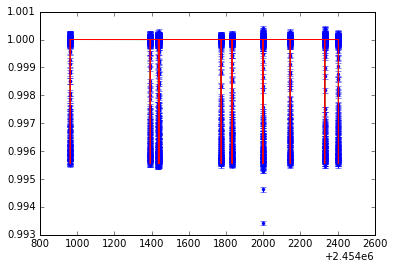

In [5]:
leastsq_fit_params, chi2_spotless = spotless_transits.fiducial_transit_fit(plots=True)

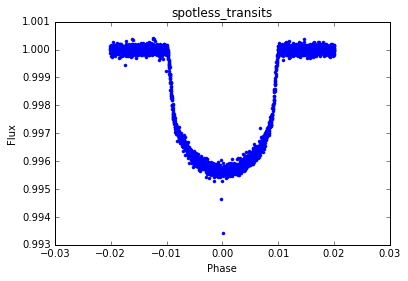

In [6]:
spotless_transits.plot(phase=True, plot_kwargs={'marker':'.', 'lw':0})

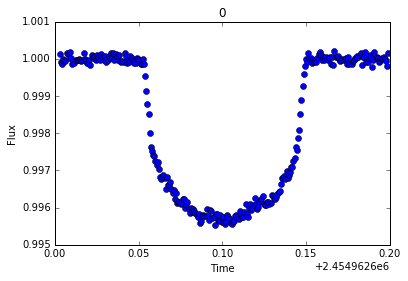

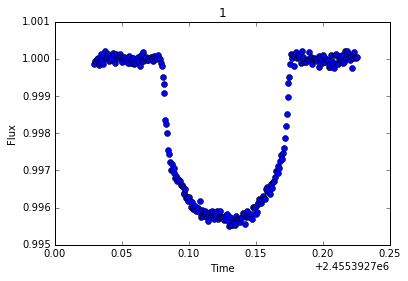

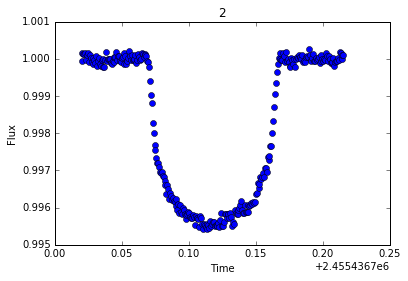

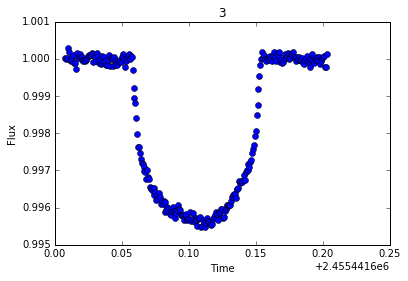

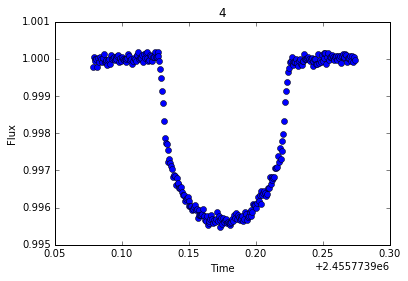

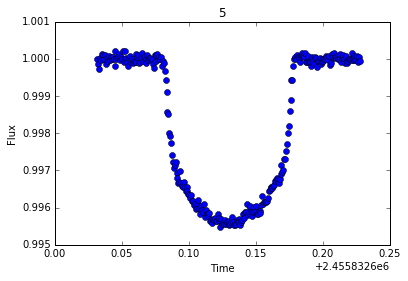

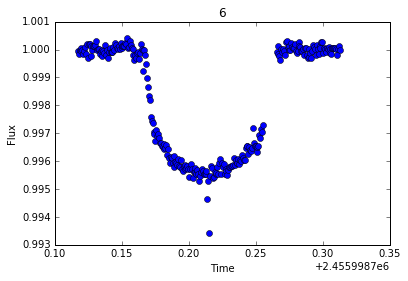

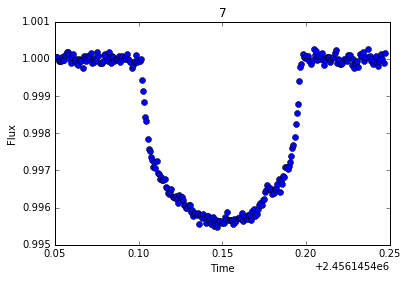

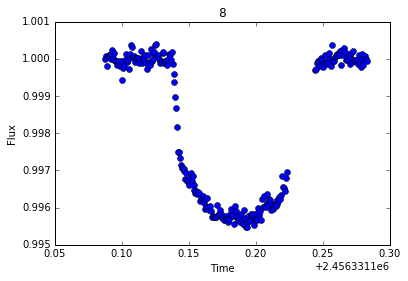

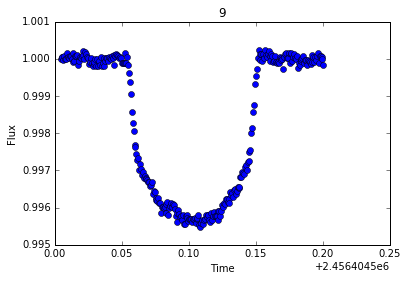

In [7]:
each_spotless_transit = spotless_transits.get_transit_light_curves()

for sptlstr in each_spotless_transit:
    sptlstr.plot()

In [8]:
print("Mean times of three 'spotless' transits: {0}"
      .format([t.times.jd.mean() for t in each_spotless_transit]))

Mean times of three 'spotless' transits: [2454962.7009082013, 2455392.8273756811, 2455436.8176223976, 2455441.7053187271, 2455774.0759595907, 2455832.7296241755, 2455998.912470079, 2456145.5488881255, 2456331.2795661958, 2456404.6023539016]


### Use `emcee` to get PDFs for interesting transit parameters

Here I'm fitting for: $t_0$, depth, duration, impact parameter and Kipping's efficient two-parameter limb-darkening terms $q_1$, $q_2$.

In [9]:
from starspots.fitting import run_emcee, plot_triangle

# Use least-sq results and Deming 2011 params to start MCMC
[t0, depth, dur, b] = [2454605.89155, 0.003365, 0.092, 0.307]#leastsq_fit_params
[q1, q2] = [0.518, 0.426] # Claret -> Kipping
p0 = [t0, depth, dur, b, q1, q2]
n_steps = 1500
transit_lc = spotless_transits
# n_steps=1000 Takes about ~3 min
samples, sampler = run_emcee(p0, transit_lc.times.jd, transit_lc.fluxes, 
                             transit_lc.errors, n_steps)

accept frac = 0.466666666667


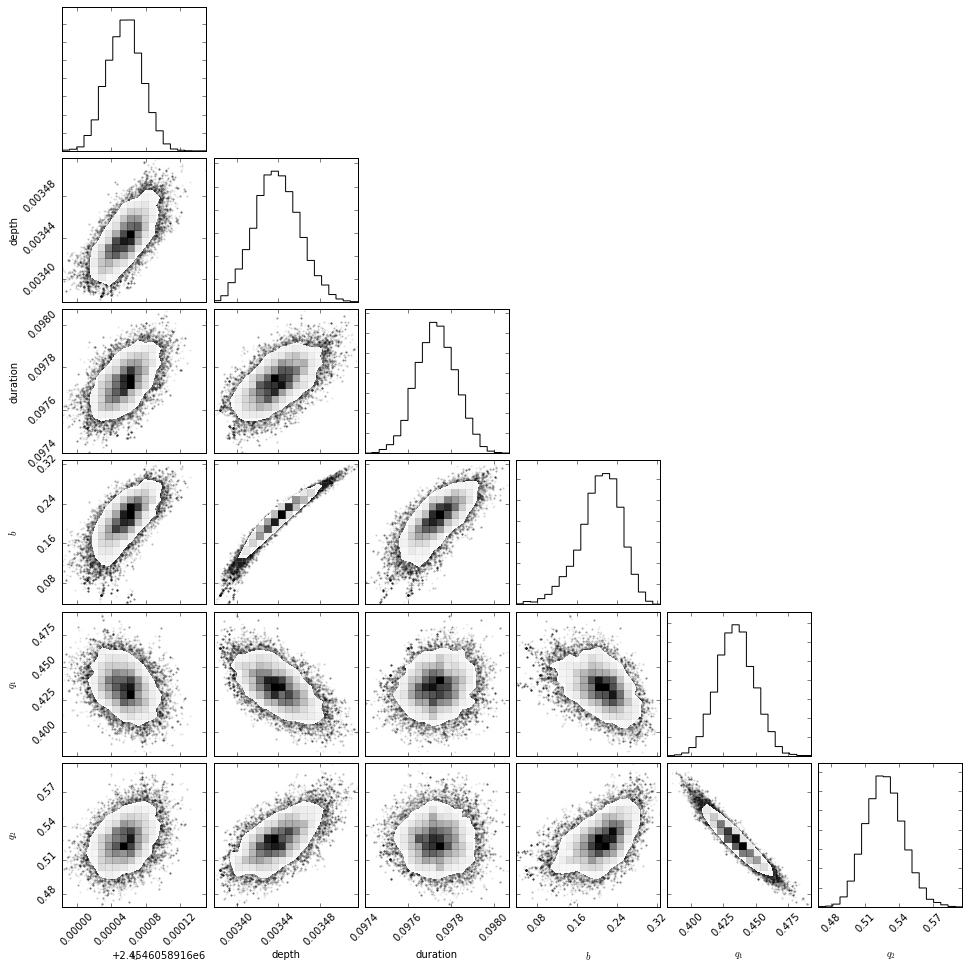

In [10]:
print("accept frac = {0}".format(np.mean(sampler.acceptance_fraction)))
plot_triangle(samples)

In [13]:
from IPython.display import display_latex, Latex
from starspots.fitting import print_emcee_results
#print_emcee_results(samples)
Latex(print_emcee_results(samples))

<IPython.core.display.Latex object>

### Fit for ephemeris using best-fit parameters from "spotless" fits

In [16]:
from starspots.fitting import run_emcee_ephemeris

# Use least-sq results and Deming 2011 params to start MCMC
depth, dur, b, q1, q2 = np.median(samples[:, 1:], axis=0)

p0 = [np.median(samples[:, 0]), 4.8878018]
bestfit_transit_params = [depth, dur, b, q1, q2]

scale_the_errors_by_a_factor_of = 1.0
# normalized_short_transits = concatenate_transit_light_curves(transits, 
#                                                              name='normalized short cadence transits')

low_chi2 = (np.log(chi2) < chi2_threshold)
low_chi2_transits = [transit for i, transit in enumerate(transits) 
                     if low_chi2[i]]
low_chi2_transits_all = concatenate_transit_light_curves(low_chi2_transits, name='low_chi2_transits')
low_chi2_transits_two = concatenate_transit_light_curves([low_chi2_transits[0], 
                                                          low_chi2_transits[-1]])

n_steps = 1800
sample_factor = 1
samples_eph, sampler_eph = run_emcee_ephemeris(p0, low_chi2_transits_two.times.jd[::sample_factor], 
                                               low_chi2_transits_two.fluxes[::sample_factor], 
                                               low_chi2_transits_two.errors[::sample_factor], 
                                               n_steps, bestfit_transit_params, 
                                               n_walkers=20)

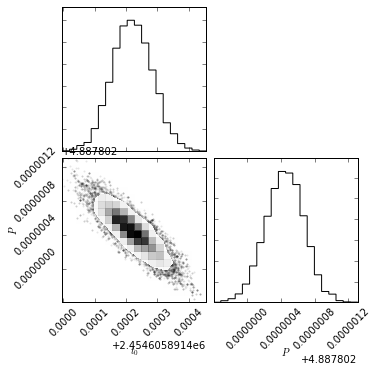

In [17]:
plot_triangle(samples_eph)

In [18]:
for i, p in enumerate(['mid-transit time', 'period']):
    mid, minus, plus = np.percentile(samples_eph[:,i], [50, 16, 84])
    print("{3}: {0:.8f} +{1:.8f} -{2:.8f}".format(mid, plus-mid, mid-minus, p))

mid-transit time: 2454605.89161896 +0.00006467 -0.00006207
period: 4.88780245 +0.00000022 -0.00000023


Now with new period measurement, fit the spotless transits again. These are the final posteriors.

In [20]:
p0 = np.median(samples[:, :], axis=0) # [t0, depth, dur, b, q1, q2]
n_steps = 2000
scale_the_errors_by_a_factor_of = 1.0
transit_lc = spotless_transits
# n_steps=1000 Takes about ~3 min
samples_refined, sampler_refined = run_emcee(p0, transit_lc.times.jd, transit_lc.fluxes, 
                                             scale_the_errors_by_a_factor_of*transit_lc.errors, 
                                             n_steps, P = np.percentile(samples_eph[:,1], 50),
                                             n_walkers=70)

/astro/users/bmmorris/.local/lib/python2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/astro/users/bmmorris/.local/lib/python2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


accept frac = 0.457635714286


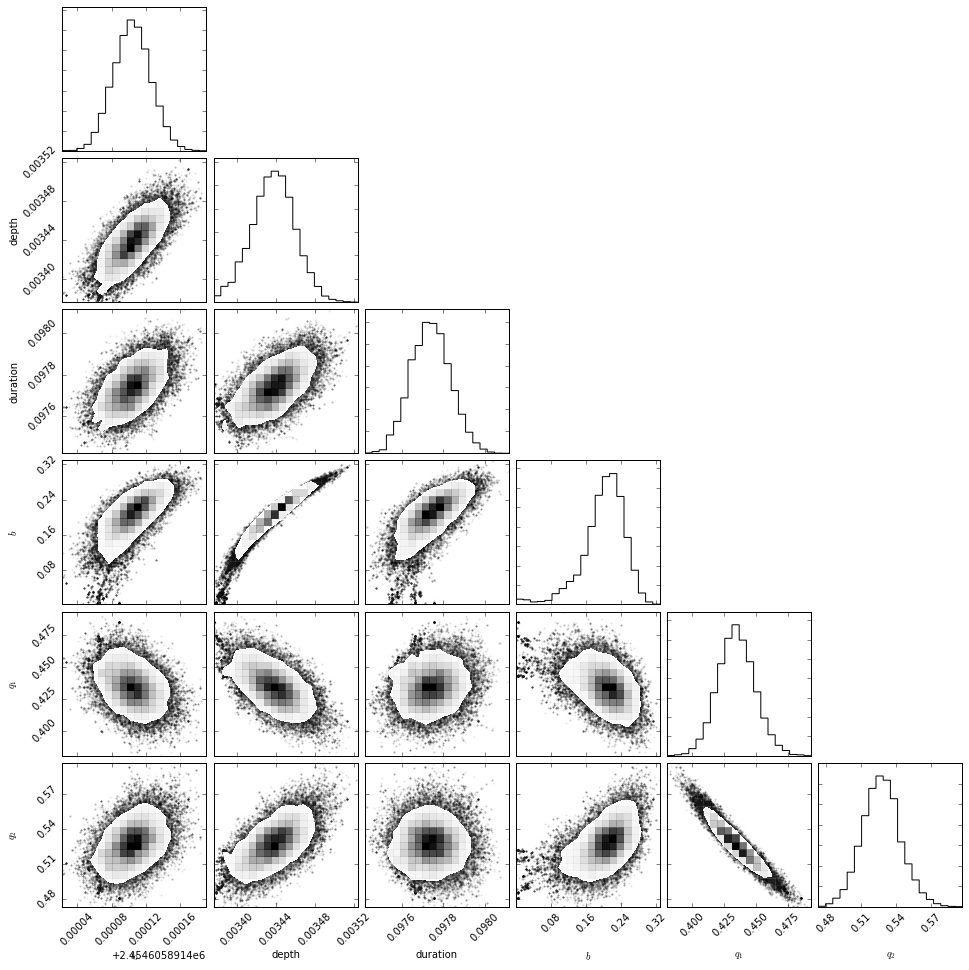

In [21]:
print("accept frac = {}".format(np.mean(sampler_refined.acceptance_fraction)))
plot_triangle(samples_refined[:, :])

In [22]:
Latex(print_emcee_results(samples_refined))

<IPython.core.display.Latex object>

In [23]:
period_mid, period_minus, period_plus = np.percentile(samples_eph[:,1], [50, 16, 84])
period_upper = period_plus-period_mid
period_lower = period_plus-period_mid
best_fit_period = mid
Latex("$P: {{{0:.8f}}}^{{+{1:.8f}}}_{{-{2:.8f}}}$"
      .format(period_mid, period_plus-period_mid, period_mid-period_minus))

<IPython.core.display.Latex object>

Create LaTeX table for paper

In [24]:
mid, minus, plus = np.percentile(samples_refined, [50, 16, 84], axis=0)
lower = mid - minus
upper = plus - mid

best_parameter_dict = {'t0': (mid[0], lower[0], upper[0]), 
                       'depth': (mid[1], lower[1], upper[1]), 
                       'duration': (mid[2], lower[2], upper[2]), 
                       'b': (mid[3], lower[3], upper[3]), 
                       'q1': (mid[4], lower[4], upper[4]), 
                       'q2': (mid[5], lower[5], upper[5]), 
                       'P': (period_mid, period_lower, period_upper)}

table_lines = ['$P$ [days] & ${{{0:.7f}}}^{{-{1:.7f}}}_{{+{2:.7f}}}$ \\\\',
                '$T_0$  [BJD] &  ${{{0}}}_{{-{1:0.6f}}}^{{+{2:0.6f}}}$ \\\\',
                '$T_{{14}}$ [days] &  ${{{0:.04f}}}_{{-{1:.04f}}}^{{+{2:.04f}}}$ \\\\',
                '$(R_p / R_s)^2$  &  ${{{0:.5f}}}_{{-{1:.5f}}}^{{+{2:.5f}}}$ \\\\',
                '$b$  &  ${{{0:.03f}}}_{{-{1:.03f}}}^{{+{2:.03f}}} $ \\\\',
                '$q_1$  & ${{{0:.2f}}}_{{-{1:.2f}}}^{{+{2:.2f}}}$ \\\\',
                '$q_2$  &  ${{{0:.2f}}}_{{-{1:.2f}}}^{{+{2:.2f}}}$ \\\\']
table_lines_order = ['P', 't0', 'duration', 'depth', 'b', 'q1', 'q2']
table_contents = ""

for line, param_i in zip(table_lines, table_lines_order):
    table_contents += line.format(*best_parameter_dict[param_i]) + '\n'

dropbox_path = '/astro/users/bmmorris/Dropbox/sharelatex/STSP_HAT-P-11/'
with open(os.path.join(dropbox_path, 'results', 'hat-11_light_curve_params.txt'), 'w') as param_table:
    param_table.write(table_contents)

In [41]:
from starspots.systemparams import aRs_i, rough_hat11_params

def kipping_to_quadratic(p):
    q1, q2 = p
    u1 = 2*np.sqrt(q1)*q2
    u2 = np.sqrt(q1)*(1 - 2*q2)
    return u1, u2

depth_refined, dur_refined, b_refined = np.median(samples_refined[:, [1, 2,3]], axis=0)

import batman
refined_params = batman.TransitParams()
refined_params.t0 = np.median(samples_refined[:, 0])
refined_params.per = period_mid
refined_params.rp = np.median(samples_refined[:, 1])**0.5
refined_params.duration = np.median(samples_refined[:, 2])
refined_params.b = np.median(samples_refined[:, 3])
refined_params.u = kipping_to_quadratic([np.median(samples_refined[:, 4]), 
                                         np.median(samples_refined[:, 5])])
refined_params.ecc = hat11_params.ecc
refined_params.w = hat11_params.w
print(refined_params.u)




a_over_Rs, inclination = aRs_i(refined_params)
print("Inclination: {0}".format(inclination))

def rho_star(transit_params):
    import astropy.units as u
    from astropy.constants import G
    """Calculate stellar density from MCMC chain samples"""
    aRs, i_deg = aRs_i(transit_params)
    print(np.percentile(aRs, 50), np.percentile(i_deg, 50))
    rho_s = 3*np.pi/(G*(transit_params.per*u.day)**2) * aRs**3
    rho_s = rho_s.to(u.g/u.cm**3)
    
    mid, minus, plus = np.percentile(rho_s, [50, 16, 84])
    lower = mid - minus
    upper = plus - mid
    
    return mid, lower, upper

rho = rho_star(refined_params)
print("Mean stellar density: {0:.2f} +{1:.2f} -{2:.2f} g cm^-3".format(*rho))

from astropy.constants import M_sun, R_sun
import astropy.units as u
print("Mean stellar density: {0:.6f} rho_sun".format((rho[0]*u.g/u.cm**3).to(M_sun/(4./3*np.pi*R_sun**3)).value))

print("Note, this is larger than the asteroseismic result "
      "from Christensen-Dalsgaard+2010 of 2.5127 g/cm^3")
dropbox_path = '/astro/users/bmmorris/Dropbox/sharelatex/STSP_HAT-P-11/'
with open(os.path.join(dropbox_path, "results", "stellar_density.txt"), 'w') as density_out:
    density_out.write("{0:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}".format(*rho))
    

(0.69508836587860812, -0.035974977045966021)
Inclination: 89.0495276508
(14.660192814497005, 89.049527650796065)
Mean stellar density: 2.49 +0.00 -0.00 g cm^-3
Mean stellar density: 1.767657 rho_sun
Note, this is larger than the asteroseismic result from Christensen-Dalsgaard+2010 of 2.5127 g/cm^3


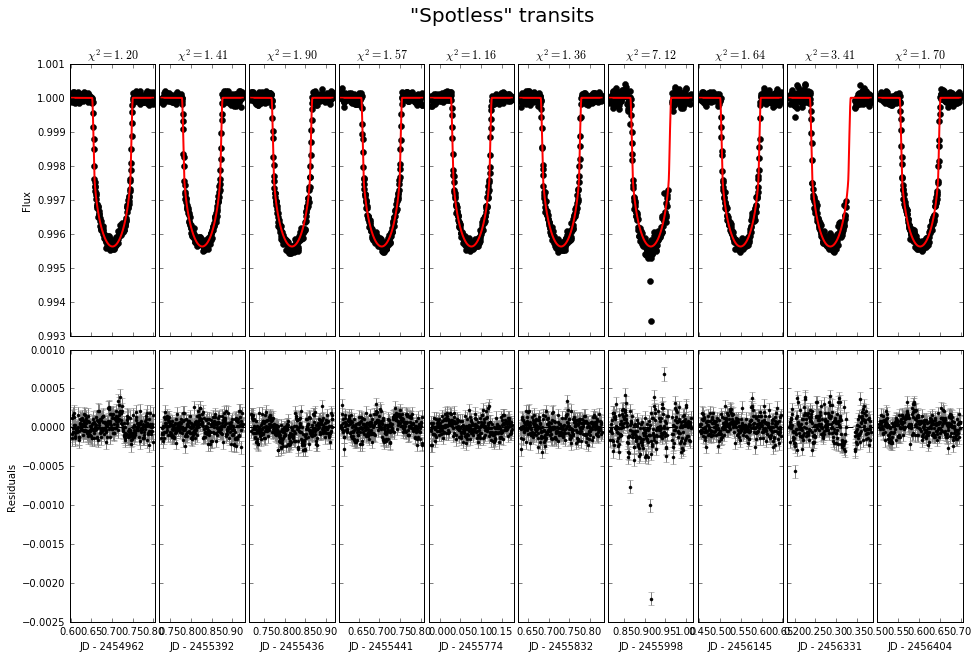

In [45]:
best_fit_results = np.median(samples_refined, axis=0)
from starspots.fitting import generate_model_lc_short

dtimes = np.diff(transit_lc.times.jd)
#t_splits = np.argwhere(dtimes > 10*np.median(dtimes)).T[0] + 1
t_splits = np.argwhere(dtimes > 1000*np.median(dtimes)).T[0] + 1
t_splits = np.concatenate([[0], t_splits, [len(dtimes)]])

fig, ax = plt.subplots(2, len(t_splits)-1, figsize=(16, 10), sharex='col', sharey='row')

for i in range(len(t_splits) - 1):
    start, stop = t_splits[i], t_splits[i+1]

    mean_jd_int = int(np.mean(transit_lc.times.jd[start:stop]))
    
    t_min = transit_lc.times.jd[start:stop].min()
    t_max = transit_lc.times.jd[start:stop].max()
    model_times = np.linspace(t_min, t_max, 3000)
    transitmodel_fine = generate_model_lc_short(model_times, 
                                           *best_fit_results, 
                                           P=np.median(samples_eph[:, 1]))

    transitmodel = generate_model_lc_short(transit_lc.times.jd[start:stop], 
                                           *best_fit_results, 
                                           P=np.median(samples_eph[:, 1]))
    
    ax[0, i].plot(transit_lc.times.jd[start:stop] - mean_jd_int, 
                  transit_lc.fluxes[start:stop], 'ko')

    ax[0, i].plot(model_times - mean_jd_int, transitmodel_fine,
                  'r', lw=2)

    ax[1, i].errorbar(transit_lc.times.jd[start:stop] - mean_jd_int, 
                      transit_lc.fluxes[start:stop] - transitmodel, 
                      transit_lc.errors[start:stop],
                      fmt='.', color='k', ecolor='gray')
    
    ax[1, i].axhline(0, ls='--', color='k')
    ax[1, i].set_xlabel("JD - {0}".format(mean_jd_int))

    transit_chi2 = (np.sum((transit_lc.fluxes[start:stop] - transitmodel)**2 / 
                           transit_lc.errors[start:stop]**2) /
                    (len(transit_lc.fluxes[start:stop]) - len(best_fit_results)))
    ax[0, i].set_title("$\chi^2 = {0:.2f}$".format(transit_chi2))
    
    ax[0, i].set_xlim([transit_lc.times.jd[start:stop].min() - mean_jd_int - 0.005, 
                       transit_lc.times.jd[start:stop].max() - mean_jd_int + 0.005])
    
ax[0, 0].set_ylabel('Flux')
ax[1, 0].set_ylabel('Residuals')
spacing = 0.05
fig.subplots_adjust(hspace=spacing, wspace=spacing)
fig.suptitle('"Spotless" transits', fontsize=20, ha='center')
#fig.savefig("../plots/splotless_transits.png", bbox_inches='tight')
plt.show()

overall reduced chi2 = 2.16697402932


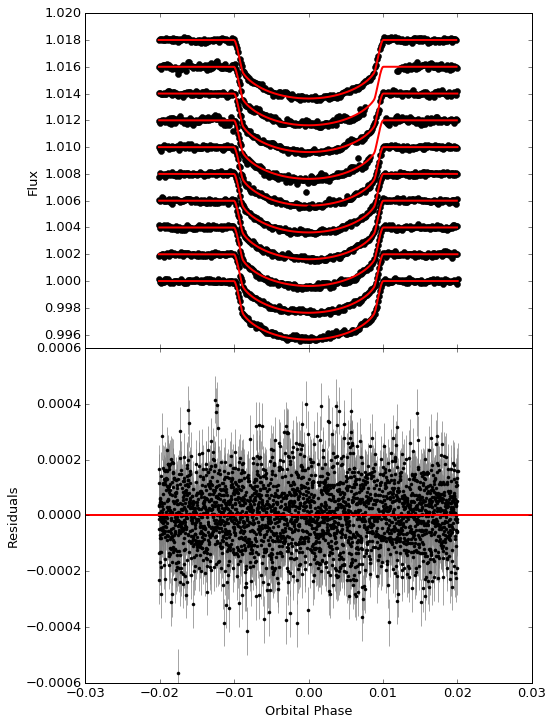

In [49]:
fig, ax = plt.subplots(2, 1, figsize=(8, 12), sharex='col', sharey='row')

def jd_to_phase(jd_array):
    phase = ((jd_array - best_fit_results[0]) % 
             np.median(samples_eph[:, 1])) / np.median(samples_eph[:, 1])
    phase[phase > 0.5] -= 1
    return phase

plt.rc('font', size=13)
transit_chi2 = []
n_fluxes = []
for i in range(len(t_splits) - 1):
    start, stop = t_splits[i], t_splits[i+1]

    #mean_jd_int = int(np.mean(transit_lc.times.jd[start:stop]))
    
    t_min = transit_lc.times.jd[start:stop].min()
    t_max = transit_lc.times.jd[start:stop].max()
    model_times = np.linspace(t_min, t_max, 3000)
    model_phase = jd_to_phase(model_times)
    transitmodel_fine = generate_model_lc_short(model_times, 
                                           *best_fit_results, 
                                           P=np.median(samples_eph[:, 1]))

    transitmodel = generate_model_lc_short(transit_lc.times.jd[start:stop], 
                                           *best_fit_results, 
                                           P=np.median(samples_eph[:, 1]))
    
    phase = jd_to_phase(transit_lc.times.jd[start:stop])
    
    offset_factor = 0.002*i
    ax[0].plot(phase,  transit_lc.fluxes[start:stop] + offset_factor, 'ko')

    ax[0].plot(model_phase, transitmodel_fine + offset_factor, 'r', lw=2)

    ax[1].errorbar(phase, 
                  transit_lc.fluxes[start:stop] - transitmodel, 
                  transit_lc.errors[start:stop],
                  fmt=',', color='gray', capsize=0, ecolor='gray', alpha=0.7)
    
    ax[1].plot(phase, transit_lc.fluxes[start:stop] - transitmodel, 
              '.', color='k')
    
    transit_chi2.append(np.sum((transit_lc.fluxes[start:stop] - transitmodel)**2 / 
                           transit_lc.errors[start:stop]**2))
    n_fluxes.append(len(transit_lc.fluxes[start:stop]))
total_chi2 = np.sum(transit_chi2)/(np.sum(n_fluxes) - 6)
print("overall reduced chi2 = {0}".format(total_chi2))

ax[1].set_xlabel('Orbital Phase')    
ax[1].axhline(0, ls='-', color='r', lw=2)
ax[0].set_ylabel('Flux')
ax[1].set_ylabel('Residuals')

# Set tick labels
ax[1].set_yticks(np.arange(-0.0006, 0.0008, 0.0002))
ax[1].set_ylim((-0.0006, 0.0006))
ax[0].set_yticks(np.arange(0.996, 1.020, 0.002))

spacing = 0.05
fig.subplots_adjust(hspace=0)
#fig.subplots_adjust(hspace=spacing, wspace=spacing)
#fig.suptitle('"Spotless" transits', fontsize=20, ha='center')
dropbox_path = '/astro/users/bmmorris/Dropbox/sharelatex/STSP_HAT-P-11/'

fig.savefig(os.path.join(dropbox_path, "figures", "spotless_transits_compact.png"), 
            bbox_inches='tight', dpi=500)
plt.show()

### Converting Kipping 2 limb darkening parameters into four-parameter law

$$ \text{Quadratic: } I(\mu)/I(1) = 1−a(1−\mu)−b(1−\mu)^2$$

$$ \text{"Nonlinear": } I(\mu)/I(1) = 1−a(1−\mu^{1/2})−b(1−\mu)-c(1-\mu^{3/2}) - d(1-\mu^2)$$

We can't convert directly from Quadratic to nonlinear, but here I'll try fitting a nonlinear model to our quadratic solution. 

In [52]:
mu = np.linspace(0, 1, 1000)

def quadratic_law(p, mu):
    u1, u2 = p
    return 1 - u1*(1-mu) - u2*(1-mu)**2

def nonlinear_law(p, mu):
    a, b, c, d = p
    return 1 - a*(1-mu**0.5) - b*(1-mu) - c*(1-mu**1.5) - d*(1-mu**2)

best_fit_quadratic = kipping_to_quadratic(np.median(samples_refined[:, -2:], axis=0))
best_quadratic_model = quadratic_law(best_fit_quadratic, mu)

u1, u2 = best_fit_quadratic

def quadratic_to_nonlinear(u1, u2):
    a1 = a3 = 0
    a2 = u1 + 2*u2
    a4 = -u2
    return (a1, a2, a3, a4)

best_fit_nonlinear = quadratic_to_nonlinear(*best_fit_quadratic)
print("Non-linear parameters (algebraic trans): {0}".format(best_fit_nonlinear))

Non-linear parameters (algebraic trans): (0, 0.62313841178667606, 0, 0.035974977045966021)


In [ ]:
# ct = np.concatenate([t.times.jd for t in each_spotless_transit])
# cf = np.concatenate([t.fluxes for t in each_spotless_transit])
# ce = np.concatenate([t.errors for t in each_spotless_transit])

# from astropy.io import ascii
# from astropy.table import Table

# tbl = Table([ct, cf, ce])
# ascii.write(tbl, 'spotless.txt')